# Time forecasting model for GHG emissions

The time forecasting of GHG emissions from pre-corona data will give us an estimate of what our current emissions would be without corona. The difference between this and our actual data will be our daily emissions savings. The following model is an Holt-Winter’s Seasonal Smoothing model following this article: https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051

To do:
- change weekly smoothing from aggregation to rolling average

Changes for new dataset:
- Change name of input file
- Find best transofrmation for stationarity - see https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788 or https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
- Find best setting for create_model function
- Change renaming in output

## Import libraries

In [169]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Load data

In [170]:
file_name = 'uk_energy_daily.csv'
data_dir = 'data/processed'
file_path = os.path.join(data_dir, file_name)
load_df = pd.read_csv(file_path, usecols = ["demand", "timestamp"], index_col = "timestamp")
load_df.index = pd.to_datetime(load_df.index)

## Remove weekly seasonlity

Daily data is seasonal (periodic) at the weekly and yearly level. One needs to be remove and weekly is the least import as their would be an element of lag and smoothing in atmospheric measurements.

In [171]:
load_df = load_df.groupby(pd.Grouper(freq='W')).mean()
seas_freq = 52 # frequency of datapoints withon season

## Explore smoothed dataset

In [172]:
load_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 474 entries, 2011-05-29 to 2020-06-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  474 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [173]:
load_df.head()

,demand
timestamp,
2011-05-29,31179.960783
2011-06-05,32792.248598
2011-06-12,33820.311689
2011-06-19,33482.346304
2011-06-26,33668.414294


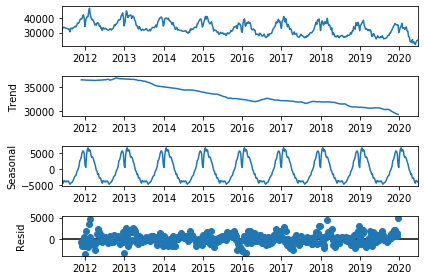

In [174]:
decomposition = seasonal_decompose(load_df)
_ = decomposition.plot() # assign to variable to avoid double plotting

## Transform data to be stationary

Define stationary test function

In [175]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(seas_freq).mean()
    rolling_std = timeseries.rolling(seas_freq).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))

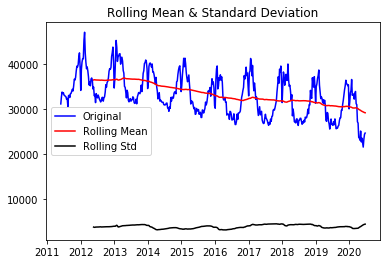

ADF Statistic: -5.176
p-value: 0.000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [176]:
get_stationarity(load_df)

## Split datasets

In [177]:
pre_corona = load_df[:'2020-01-01']
post_corona  = load_df['2020-01-01':]

In [178]:
train = pre_corona[:'2018-01-01']
test  = pre_corona['2018-01-01':]

## Holt-Winter’s Seasonal Smoothing model

In [179]:
def create_model(timeseries):
    model = ExponentialSmoothing(timeseries, trend="add", seasonal="add", seasonal_periods=seas_freq, damped=True)
    model_fitted = model.fit()
    return model_fitted

### Use train-test split to decide hyper-parameters

In [180]:
model_eval = create_model(train)

C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [181]:
model_eval.summary()

Dep. Variable:,endog,No. Observations:,345
Model:,ExponentialSmoothing,SSE,443261838.571
Optimized:,True,AIC,4966.814
Trend:,Additive,BIC,5185.896
Seasonal:,Additive,AICC,4991.656
Seasonal Periods:,52,Date:,"Thu, 18 Jun 2020"
Box-Cox:,False,Time:,10:02:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3873196,alpha,True
smoothing_slope,0.3872507,beta,True


In [182]:
pred_train = model_eval.predict(train.index.min(), train.index.max())
rmse_train = np.sqrt(np.mean(np.square(train.values-pred_train.values)))

In [183]:
pred_test = model_eval.predict(test.index.min(), test.index.max())
rmse_test = np.sqrt(np.mean(np.square(test.values-pred_test.values)))

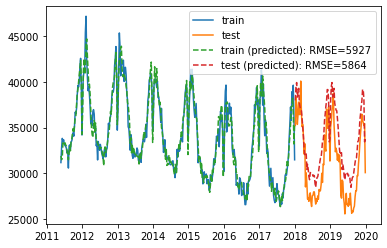

In [184]:
fig, ax = plt.subplots()
ax.plot(train.index, train.values, label = 'train')
ax.plot(test.index, test.values, label='test')
ax.plot(train.index, pred_train.values, linestyle = '--',
        label = f'train (predicted): RMSE={rmse_train:.0f}')
ax.plot(test.index, pred_test.values, linestyle = '--',
        label = f'test (predicted): RMSE={rmse_test:.0f}')
ax.legend(loc = 'best')

### Use with-without corona split to evaluate carbon savings

In [185]:
model = create_model(without_corona)

C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [186]:
uk_emissions_2020 = with_corona.rename(columns = {'demand': 'with_corona'})
uk_emissions_2020['without_corona'] = model.predict(with_corona.index.min(), with_corona.index.max())
uk_emissions_2020['reduction'] = uk_emissions_2020['without_corona']-uk_emissions_2020['with_corona']

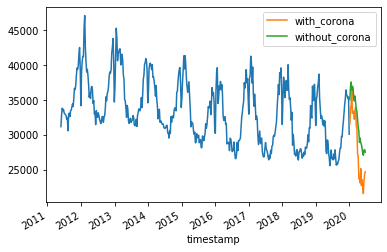

In [187]:
fig, ax = plt.subplots()
ax.plot(pre_corona.index, pre_corona.values, label = 'pre_corona')
uk_emissions_2020[['with_corona','without_corona']].plot(ax=ax)

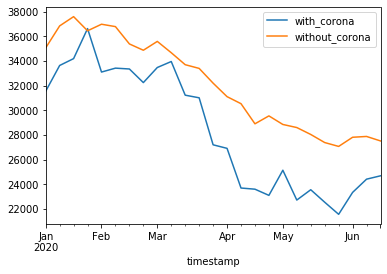

In [188]:
uk_emissions_2020[['with_corona','without_corona']].plot()

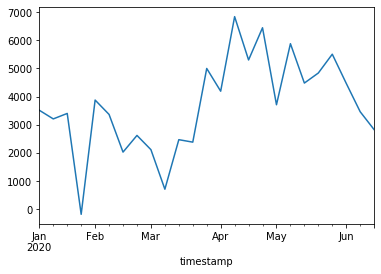

In [189]:
uk_emissions_2020['reduction'].plot()

## Output processed data


In [190]:
proc_data_dir = 'data/processed'
if not os.path.exists(proc_data_dir):
    os.makedirs(proc_data_dir)

In [191]:
file_name = 'uk_emissions_reduction.csv'
file_path = os.path.join(proc_data_dir, file_name)

In [192]:
uk_emissions_2020.to_csv(filename)

NameError: name 'filename' is not defined